NAIVE BAYES CLASSIFIER STROKE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
#Open File 
df=pd.read_excel(r'C:\Users\gadwi\Naive Bayes Classifier\Data statkom rev.xlsx')
df.head()


,gender,age,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,hypertension,heart_disease
0,Male,Lansia,Yes,Private,Urban,>200 mg/dl,Obesitas,formerly smoked,y,t,y
1,Male,Lansia,Yes,Private,Rural,100-200 mg/dl,Obesitas,never smoked,y,t,y
2,Female,Orang Tua,Yes,Private,Urban,100-200 mg/dl,Obesitas,smokes,y,t,t
3,Female,Lansia,Yes,Self-employed,Rural,100-200 mg/dl,Normal,never smoked,y,y,t
4,Male,Lansia,Yes,Private,Urban,100-200 mg/dl,BB Berlebih,formerly smoked,y,t,t


In [3]:
unique_classes = df['stroke'].unique()
unique_classes

array(['y', 't'], dtype=object)

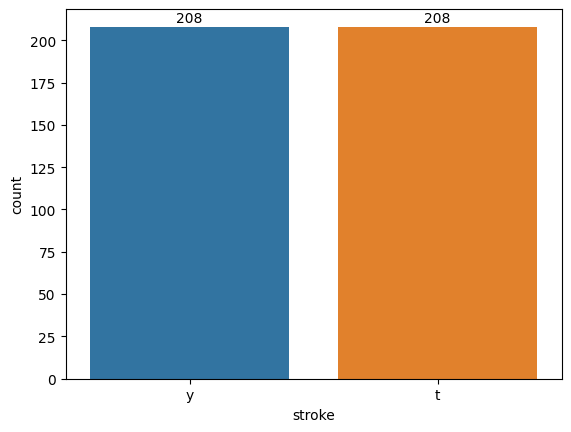

In [4]:
# Mengumpulkan jumlah data untuk setiap kategori
counts = df['stroke'].value_counts()

# Membuat countplot
ax = sns.countplot(data=df, x='stroke')

# Menambahkan label jumlah data di atas setiap bar
for i, count in enumerate(counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10, color='black')

sns.countplot(data=df, x='stroke')
plt.show()

In [5]:
#Deklarasi kolom stroke sebagai variabel targget
X = df.drop('stroke', axis=1)
y = df['stroke']
feature_columns = X.columns

In [6]:
#stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=125)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [7]:
print("Number of train and test data: ", len(X_train), len(X_test))

Number of train and test data:  291 125


C:\Users\gadwi\AppData\Local\Temp\ipykernel_25392\104829099.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


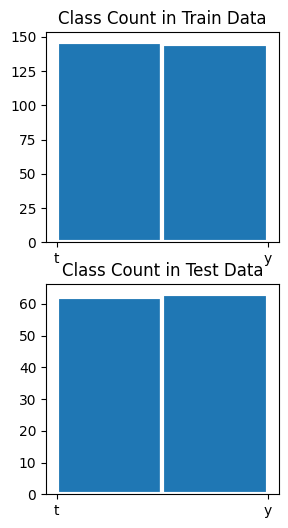

In [8]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(3,6))

ax1.hist(y_train, bins=2, linewidth=3, edgecolor="white")
ax1.set_title("Class Count in Train Data")
ax2.hist(y_test, bins=2, linewidth=3, edgecolor="white")
ax2.set_title("Class Count in Test Data")

fig.show()

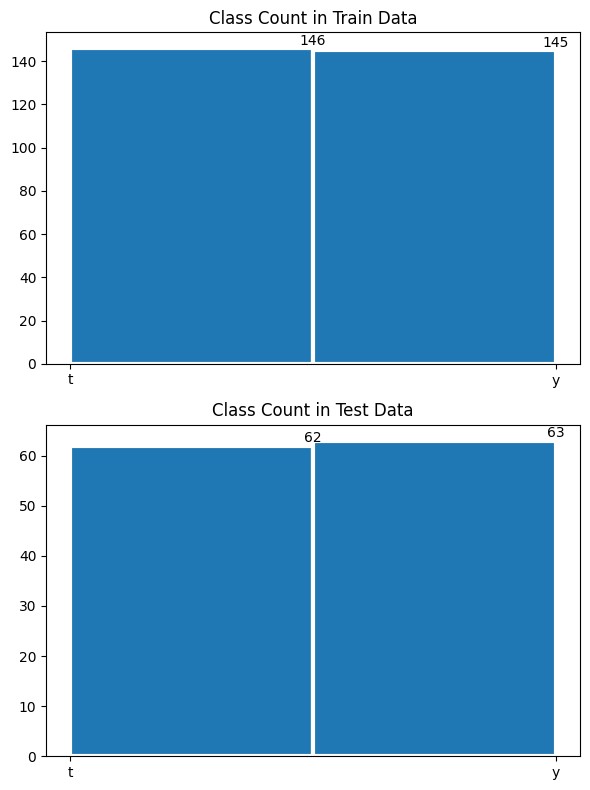

In [9]:

fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 8))

# Plotting histograms
hist_train, bins_train, _ = ax1.hist(y_train, bins=2, linewidth=3, edgecolor="white")
hist_test, bins_test, _ = ax2.hist(y_test, bins=2, linewidth=3, edgecolor="white")

# Adding text annotations
for i, count in enumerate(hist_train):
    ax1.text(bins_train[i] + 0.5, count + 0.05, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

for i, count in enumerate(hist_test):
    ax2.text(bins_test[i] + 0.5, count + 0.05, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

# Setting titles
ax1.set_title("Class Count in Train Data", fontsize=12)
ax2.set_title("Class Count in Test Data", fontsize=12)

# Adjust layout
plt.tight_layout()

# Increase font size of x-axis tick labels for better readability
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='both', labelsize=10)

# Rotate x-axis labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# Show the plot
plt.show()

Naive Bayes Predictor

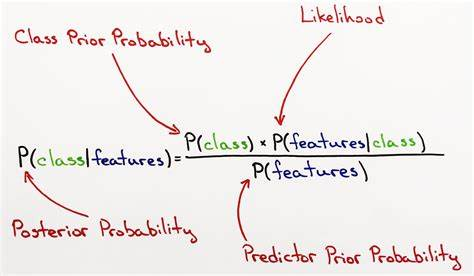

In [10]:
def likelihood_calc(train_data, train_labels, feature_columns, unique_classes):
    '''Here we'll calculate the likelihood and record the probabilities in a copy of the
       training dataframe. We'll be returning that dataframe at the end of the func.
    '''

    train_record = train_data.copy()

    #Iterate through the classes and calculate the likelihood for each class.
    for cls_idx, cls_name in enumerate(unique_classes):

        for feat_idx, feat_name in enumerate(feature_columns):

            #filter the training data based on the class and the column.
            filtered_train_df = train_data.loc[train_labels == cls_name, feat_name]

            #identify the unique values and the count of those values from the column.
            unique, count = np.unique(filtered_train_df, return_counts=True)

            #calculate the probability & record them in a dictionary (count/total class data)
            count_dict = dict(zip(unique, count/len(filtered_train_df)))

            #let's substitute the values for the probabilities.
            likelihood_values = train_record.loc[train_labels == cls_name, feat_name]\
                                    .map(count_dict)
            indices = likelihood_values.index.tolist()
            values = likelihood_values.values

            #record the probabilities in the train record dataframe.
            train_record.loc[indices, feat_name] = values

    #for convenience, we'll append the actual class labels in the record.
    train_record['class'] = train_labels

    return train_record

In [11]:
def class_prior_calc(unique_classes, train_record):
    '''Calculation of the prior. We'll record the prior values in the train record dataframe
       in a separate column. We'll also add the actual class column for convenience.
    '''

    train_record['class_prior'] = np.nan

    for cls_idx, cls_name in enumerate(unique_classes):

        total_cls_num = train_record[train_record['class']==cls_name].shape[0]
        cls_probability = total_cls_num/train_record.shape[0]
        train_record.loc[train_record['class']==cls_name, 'class_prior'] = cls_probability

    return train_record

In [12]:
def cross_reference(test_data, train_record, train_data):
    '''Uses the train record to find the location of the features and cross-reference
       to the record to find the likelihood.
    '''
    #compare the test column values with the train column values and find its index.
    indices = train_data.index[train_data.isin([test_data])].tolist()
    #this occurs if the feature is not present in the train data.
    if len(indices) == 0:
        return 0

    #we need the [0] because the train data most likely contain duplicates and therefore
    #it returns a list of indices. We only need one since all of them are duplicates.
    likelihood_prob = train_record.loc[indices[0]]

    return likelihood_prob


def calc_posterior_prob_per_row(row, cls_name, train_record):
    '''Given the row data of likelihood probabilities, use the class prior from train record
       to calculate the posterior probability of a class.
    '''

    #filter the class that we want and get its class prior.
    #the result of this line will most likely be a huge single-column dataframe with
    #duplicate values.
    class_prior = train_record[train_record['class'] == cls_name]['class_prior']
    class_prior = class_prior.tolist()[0] #hence the indexing.

    likelihood_probs_product = np.prod(row) #multiply the likelihoods of the features.

    posterior_prob = class_prior * likelihood_probs_product #as per our derived N.B. equation

    return posterior_prob



def calc_posterior_prob(test_data, unique_classes, feature_columns, train_data,
                            train_record):
    '''Calculate the posterior probability of the test data.
    '''

    #we're gonna need a copy of the test dataframe for each class.
    test_records = {}

    #cross-refer and identify the likelihood probabilities.
    for cls_idx, cls_name in enumerate(unique_classes):

        test_records[cls_name] = test_data.copy()

        #filter the train data and train record according to the classes.
        train_data_class_filtered = train_data.loc[train_record['class'] == cls_name]
        train_record_class_filtered = train_record.loc[train_record['class'] == cls_name]

        for _, feat_name in enumerate(feature_columns):

            #extract the column data from all 3 dataframes.
            test_data_column = test_data[feat_name]
            train_data_column = train_data_class_filtered[feat_name]
            train_record_column = train_record_class_filtered[feat_name]

            #We're going to identify whether or not the value exist in the train data
            #and if it is, we'll cross-reference for it's likelihood probability from
            #the train record df. Else, return 0.
            test_records[cls_name][feat_name] = test_data_column.apply(
                                                        lambda x:cross_reference(
                                                        test_data=x,
                                                        train_record=train_record_column,
                                                        train_data=train_data_column))

    #calculate the posterior probability.
    for cls_idx, cls_name in enumerate(unique_classes):

        test_records[cls_name]['posterior'] = test_records[cls_name].apply(
                                                    lambda x: calc_posterior_prob_per_row(
                                                        row=x, cls_name=cls_name,
                                                        train_record=train_record), axis=1)


    return test_records

In [13]:
def get_max_class_prediction(test_records, unique_classes):
    '''Given the posterior probabilities of all classes, find the highest prob.
    '''
    predictions = {}

    for cls_idx, cls_name in enumerate(unique_classes):

        predictions[cls_name] = test_records[cls_name]['posterior']

    predictions = pd.DataFrame.from_dict(predictions)
    max_preds = predictions.idxmax(axis=1)

    return max_preds

In [14]:
def check_accuracy(predictions, actual_labels):
    '''Compare the predictions with the test labels.
    '''

    comparison = predictions == actual_labels
    accuracy = comparison.sum()/len(actual_labels) * 100

    return accuracy

In [15]:
train_record = likelihood_calc(train_data=X_train,
                train_labels=y_train,
                feature_columns=feature_columns,
                unique_classes=unique_classes)

In [16]:
train_record = class_prior_calc(unique_classes=unique_classes,
                                train_record=train_record)

train_record.head()

,gender,age,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,hypertension,heart_disease,class,class_prior
0,0.671233,0.164384,0.321918,0.116438,0.458904,0.575342,0.239726,0.383562,0.883562,0.945205,t,0.501718
1,0.586207,0.4,0.875862,0.6,0.572414,0.462069,0.427586,0.158621,0.303448,0.827586,y,0.498282
2,0.586207,0.593103,0.875862,0.6,0.427586,0.303448,0.393103,0.158621,0.696552,0.827586,y,0.498282
3,0.586207,0.593103,0.875862,0.6,0.427586,0.303448,0.393103,0.248276,0.303448,0.827586,y,0.498282
4,0.586207,0.593103,0.875862,0.6,0.572414,0.234483,0.427586,0.393103,0.303448,0.827586,y,0.498282


In [17]:
test_records = calc_posterior_prob(test_data=X_test, unique_classes=unique_classes,
                    feature_columns=feature_columns,
                   train_data=X_train,
                   train_record=train_record)

In [18]:
predictions = get_max_class_prediction(test_records=test_records,
                                       unique_classes=unique_classes)
predictions.head(10)

0    t
1    t
2    y
3    y
4    y
5    t
6    y
7    y
8    y
9    y
dtype: object

In [19]:
import pandas as pd
import numpy as np

# Assuming you have the necessary imports and variable initializations here

# Call the function to calculate class priors
train_record = class_prior_calc(unique_classes=unique_classes, train_record=train_record)

# Call the function to calculate posterior probabilities
test_results = calc_posterior_prob(test_data=, unique_classes, feature_columns, train_data, train_record)

# Display the results based on categories
for cls_name in unique_classes:
    print(f"Results for Class: {cls_name}")
    print(test_results[cls_name][['posterior']])
    print("\n")


SyntaxError: invalid syntax (2762723851.py, line 10)

In [ ]:
accuracy = check_accuracy(predictions=predictions,
                          actual_labels=y_test)

print("The accuracy of the predictions is: ", accuracy)

The accuracy of the predictions is:  78.4


GUI NAIVE BAYES CLASSIFIER PREDICT

In [ ]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the dataset
df = pd.read_excel(r'C:\Users\gadwi\Naive Bayes Classifier\Data statkom rev.xlsx')

# Extract unique classes
unique_classes = df['stroke'].unique()

# Feature columns
feature_columns = df.columns[df.columns != 'stroke']

# Dropdown widgets for user input
dropdown_widgets = {}
for column in feature_columns:
    if column == 'gender':
        values = ['Male', 'Female']
    elif column == 'age':
        values = ['Dewasa', 'Lansia', 'Orang Tua', 'Remaja']
    elif column == 'ever_married':
        values = ['Yes', 'No']
    elif column == 'work_type':
        values = ['childern', 'Govt_job', 'Self-employed', 'Private']
    elif column == 'Residence_type':
        values = ['Urban', 'Rural']
    elif column == 'avg_glucose_level':
        values = ['0-100 mg/dl', '100-200 mg/dl', '>200 mg/dl']
    elif column == 'bmi':
        values = ['Obesitas', 'Normal', 'BB Berlebih', 'Kurus']
    elif column == 'smoking_status':
        values = ['smokes', 'never smoked', 'formerly smoked', 'Unknown']
    else:
        values = df[column].unique()

    dropdown_widgets[column] = widgets.Dropdown(options=values, description=f'{column}: ', style={'description_width': 'initial'})

# Submit button
submit_button = widgets.Button(description="Predict Stroke", button_style='success')

# Output widgets to display user input and prediction result
output_user_input = widgets.Output(layout={'border': '1px solid black', 'padding': '10px', 'margin': '10px 0'})
output_prediction_result = widgets.Output(layout={'border': '1px solid black', 'padding': '10px', 'margin': '10px 0'})

# Function to handle prediction when the submit button is clicked
def on_submit_button_clicked(b):
    # Get user input
    user_input = {}
    for column, dropdown in dropdown_widgets.items():
        user_input[column] = dropdown.value

    # Display user input
    with output_user_input:
        clear_output(wait=True)
        print("User Input:")
        for column, value in user_input.items():
            print(f"{column}: {value}")

    # Prepare user input for prediction
    user_input_df = pd.DataFrame([user_input])
    user_input_df = user_input_df[feature_columns]  # Rearrange columns if needed

    # Perform Naive Bayes prediction
    test_records = calc_posterior_prob(test_data=user_input_df,
                                       unique_classes=unique_classes,
                                       feature_columns=feature_columns,
                                       train_data=X_train,
                                       train_record=train_record)

    predictions = get_max_class_prediction(test_records=test_records,
                                           unique_classes=unique_classes)

    # Display prediction result
    with output_prediction_result:
        clear_output(wait=True)
        print("Prediction Result:")
        print(f"Stroke Prediction: {predictions[0]}")  # Assuming binary classification, adjust accordingly

# Set the function to be called when the button is clicked
submit_button.on_click(on_submit_button_clicked)

# Display widgets
user_input_widgets = [dropdown_widgets[column] for column in feature_columns]
user_input_widgets.append(submit_button)

# Center align user input and prediction result
output_user_input.layout.align_items = 'center'
output_prediction_result.layout.align_items = 'center'

display(widgets.VBox(user_input_widgets))
display(output_user_input)
display(output_prediction_result)


Output(layout=Layout(align_items='center', border_bottom='1px solid black', border_left='1px solid black', bor…

Output(layout=Layout(align_items='center', border_bottom='1px solid black', border_left='1px solid black', bor…